In [1]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm.auto import tqdm
from IPython.display import clear_output
from sklearn.metrics import accuracy_score, f1_score

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
DATA_PATH = 'imagewoof2-320'
NUM_WORKERS = 4
SIZE_H = SIZE_W = 128
NUM_CLASSES = 10
EPOCH_NUM = 10
image_mean = [0.5, 0.5, 0.5]
image_std  = [0.25, 0.25, 0.25]
EMBEDDING_SIZE = 128
BATCH_SIZE = 256

In [4]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        
    transforms.ToTensor(),                      
    transforms.Normalize(image_mean, image_std)
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [6]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [8]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

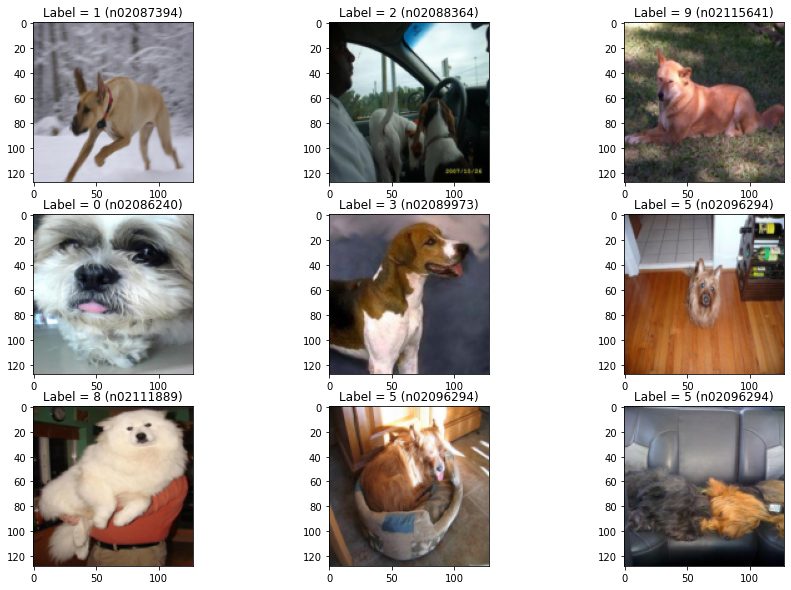

In [9]:
plot_from_batch_generator(train_batch_gen)

In [52]:
def accuracy(scores, labels):
    assert type(scores) is np.ndarray and type(labels) is np.ndarray
    predicted = scores.argmax(axis=1)
    return np.mean(predicted == labels)

def f1(scores, labels):
    assert type(scores) is np.ndarray and type(labels) is np.ndarray
    predicted = scores.argmax(axis=1)
    return f1_score(labels, predicted, average='macro')

tracked_metrics = {
    'accuracy': accuracy,
    'f1-score': f1
}

def calculate_metrics(scores, labels, print_log=False):
    """ Compute all the metrics from tracked_metrics dict using scores and labels."""
    
    assert len(labels) == len(scores), print('Label and score lists are of different size')
    
    scores_array = np.array([tensor.numpy() for tensor in scores])
    labels_array = np.array(labels)
    
    metric_results = {}
    for k,v in tracked_metrics.items():
        metric_value = v(scores_array, labels_array)
        metric_results[k] = metric_value
    
    if print_log:
        print(' | '.join(['{}: {:.4f}'.format(k,v) for k, v in metric_results.items()]))
    
    return metric_results


def get_score_distributions(epoch_result_dict):
    """ Return per-class score arrays."""
    scores = epoch_result_dict['scores']
    labels = epoch_result_dict['labels']
    
    # save per-class scores
    for class_id in [0, 1]:
        epoch_result_dict['scores_' + str(class_id)] = np.array(scores)[np.array(labels) == class_id]
    
    return epoch_result_dict

In [45]:
loss_function = nn.CrossEntropyLoss()

def compute_loss(model, data_batch):
    """ Compute the loss using loss_function for the batch of data and return mean loss value for this batch."""
    # load the data
    img_batch = data_batch['img']
    label_batch = data_batch['label']
    
    # forward pass
    logits = model(img_batch)
    
    # loss computation
    loss = loss_function(logits, label_batch)
    
    return loss, model

In [46]:
@torch.no_grad()
def test_model(model, batch_generator, subset_name='test', print_log=True, plot_scores=False):
    model.train(False)
    
    score_list = []
    label_list = []
    loss_list = []
    
    for X_batch, y_batch in batch_generator:
        logits = model(X_batch.to(device))
        softmax = nn.Softmax(dim=1)
        scores = softmax(logits)
        labels = y_batch.numpy().tolist()
        loss = loss_function(logits, y_batch.to(device))
        
        loss_list.append(loss.detach().cpu().numpy().tolist())
        score_list.extend(scores)
        label_list.extend(labels)
        
    metric_results = calculate_metrics(score_list, label_list, print_log)
    metric_results['scores'] = score_list
    metric_results['labels'] = label_list
    metric_results['loss'] = loss_list
    
    return metric_results

In [59]:
def train_model(model, train_batch_generator, val_batch_generator, opt, ckpt_name=None, n_epochs=EPOCH_NUM, visualize=True):
    
    train_loss, val_loss = [], [1]
    val_loss_idx = [0]
    best_model = None
    top_val_accuracy = 0
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        model.train(True)
        for (X_batch, y_batch) in tqdm(train_batch_generator, desc='Training', leave=False):
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            data_batch = {'img': X_batch, 'label': y_batch}
            loss, model = compute_loss(model, data_batch)
            
            # backward pass
            loss.backward()
            opt.step()
            train_loss.append(loss.detach().cpu().numpy())
        
        metric_results = test_model(model, val_batch_generator, subset_name='val')
        # metric_results = get_score_distributions(metric_results)
        val_loss_value = np.mean(metric_results['loss'])
        val_loss_idx.append(len(train_loss))
        val_loss.append(val_loss_value)
        
        if visualize:
            clear_output()
            fig = plt.figure(figsize=(8,5))
            plt.plot(train_loss, color='b', label='train')
            plt.plot(val_loss_idx, val_loss, color='c', label='val')
            plt.legend()
            plt.title('Train/val loss.')
            plt.show()
            
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, n_epochs, time.time() - start_time))
        val_accuracy_value = metric_results['accuracy']
        if val_accuracy_value > top_val_accuracy and ckpt_name is not None:
            top_val_accuracy = val_accuracy_value
            
            # save checkpoint of the best model to disk
            with open(ckpt_name, 'wb') as f: torch.save(model, f)
        
    return model, opt

In [7]:
def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Flatten(nn.Module):
    def forward(self, x):
        return torch.flatten(x, start_dim=1)

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.model = nn.Sequential(
            conv_block_3x3(3, 32),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(32, 64),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(64, 64),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(64, 128),
            nn.MaxPool2d((2, 2)),
            conv_block_3x3(128, 128),
            nn.MaxPool2d((2, 2)),
            nn.AdaptiveMaxPool2d(1),
            Flatten()
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, EMBEDDING_SIZE),
            nn.ReLU()
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [8]:
model_cnn = MyModel()
summary(model_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]          73,856
      BatchNorm2d-14          [-1, 128,

c:\programdata\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


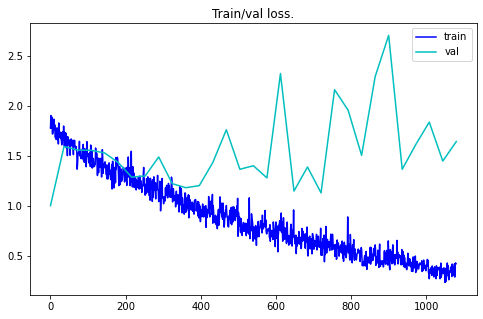

Epoch 30 of 30 took 166.931s


In [60]:
model_cnn = model_cnn.to(device)
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
ckpt_name_cnn='model_cnn.ckpt'
model_cnn_norm, opt = train_model(model_cnn, train_batch_gen, val_batch_gen, opt, ckpt_name=ckpt_name_cnn)